## NeuRIPs Multi-resolution tests

Purpose: Scrapes final NeurIPS results for multi-resolution evaluations from Weights & Biases. This notebook contains all computed performance metrics.

Associated Tables: Table 5, Table 6, Table 7, Table 8

Author: Alexander Ratzan

Project: Predicting Functional Brain Connectivity with Context-Aware Deep Neural Networks (NeurIPS 2025)


### Imports

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from env.imports import *

In [27]:
import sys
import os

from sim.wandb_scrape import (
    fetch_and_summarize_wandb_runs, 
    process_model_feature_combinations,
    plot_model_barchart,
    plot_true_vs_null_model_barchart,
    api
)
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### Wandb API Query

In [28]:
# Experiment configuration
MODELS = ['shared_transformer', 'shared_transformer_cls']
CV_TYPES = ['random', 'spatial'] 
NULL_MODELS = ['none', 'spin']
DATASETS = ['iPA183', 'iPA391', 'iPA729', 'HCP']

# Time range for recent experiments (past 7 days)
WITHIN_LAST_DAYS = 30
BEFORE_LAST_DAYS = 0

def log_message(message, level="INFO"):
    """Print timestamped log message."""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {level}: {message}")

def fetch_wandb_runs_with_parcellation(model, cv_type, null_model, dataset, feature_type='transcriptome', target='FC', gene_list='0.2', within_last=7, before_last=0):
    """
    Custom fetch function that handles BHA2 datasets with parcellation tags.
    
    Args:
        model (str): Model name
        cv_type (str): CV type  
        null_model (str): Null model
        dataset (str): Dataset name (iPA183, iPA391, iPA729, or HCP)
        Other args: Same as fetch_and_summarize_wandb_runs
    
    Returns:
        summary_df: Same as fetch_and_summarize_wandb_runs
    """
    from datetime import datetime, timedelta
    
    # Set time filters
    end_time = datetime.now() - timedelta(days=before_last)
    start_time = datetime.now() - timedelta(days=within_last)
    
    # Set expected number of runs based on cv_type
    if cv_type == "schaefer":
        expected_runs = 9
    elif cv_type == "lobe":
        expected_runs = 6
    else:  # random or spatial
        expected_runs = 40
    
    # Build required tags
    required_tags = [
        "final_eval",
        f"model_{model}",
        f"target_{target}",
        f"cv_type_{cv_type}",
        f"gene_list_{gene_list}",
        f"null_model_{null_model}",
        f"feature_type_{feature_type}"
    ]
    
    # Add dataset-specific tags
    if dataset == 'HCP':
        required_tags.append("dataset_HCP")
    else:
        required_tags.append("dataset_BHA2")
        # Add parcellation tag for BHA2 datasets
        parcellation_number = dataset[3:]  # Extract number from iPA183 -> 183
        required_tags.append(f"parcellation_iPA_{parcellation_number}")
    
    filters = {
        "tags": {
            "$all": required_tags
        },
        "created_at": {
            "$gte": start_time.isoformat(), 
            "$lte": end_time.isoformat()
        },
        "state": "finished"
    }
    
    print(f"🔍 Fetching runs for: model={model}, cv_type={cv_type}, null_model={null_model}, dataset={dataset}")
    print(f"    Required tags: {required_tags}")
    
    runs = api.runs("sidharthgoel/gx2conn", filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        # Attempt to extract the pearson_r value (or set to NaN if missing)
        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        # Only consider runs with meaningful final_test_metrics
        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    if len(df) == 0:
        raise ValueError(f"❌ No runs found for this combination.")

    # Deduplicate by run_name using highest test pearson_r
    df_unique = (
        df.sort_values("final_test_pearson_r", ascending=False)
          .drop_duplicates("run_name", keep="first")
    )
    
    print(f"    Found {len(df)} total runs, {len(df_unique)} unique after deduplication (expected {expected_runs})")
    
    if len(df_unique) == 0:
        raise ValueError(f"❌ No unique runs found after deduplication.")

    # Clean and summarize
    columns_to_drop = ["run_name", "run_id", "final_test_pearson_r"]
    df_clean = df_unique.drop(columns=columns_to_drop, errors="ignore")

    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std()
    }).T
    
    return summary_df

def quick_overview():
    """
    Quick overview of available runs before full analysis.
    Returns summary of what's available vs missing.
    """
    log_message("Starting quick overview of available runs...")
    print("=" * 80)
    print("QUICK OVERVIEW - RECENT RUNS (PAST 7 DAYS)")
    print("=" * 80)
    
    available_combinations = []
    missing_combinations = []
    total_expected = len(MODELS) * len(CV_TYPES) * len(NULL_MODELS) * len(DATASETS)
    
    for dataset in DATASETS:
        print(f"\n📊 Dataset: {dataset}")
        dataset_available = 0
        
        for model in MODELS:
            model_short = 'SMT' if model == 'shared_transformer' else 'SMT+CLS'
            
            for cv_type in CV_TYPES:
                for null_model in NULL_MODELS:
                    try:
                        # Use custom function that handles parcellation tags
                        summary_df = fetch_wandb_runs_with_parcellation(
                            model=model,
                            cv_type=cv_type,
                            null_model=null_model,
                            dataset=dataset,
                            feature_type='transcriptome',
                            within_last=WITHIN_LAST_DAYS,
                            before_last=BEFORE_LAST_DAYS
                        )
                        
                        # Extract key metric
                        if 'test_pearson_r' in summary_df.columns:
                            pearson_r = summary_df.loc['mean', 'test_pearson_r']
                            print(f"  ✅ {model_short:8} | {cv_type:7} | {null_model:4} | r={pearson_r:.3f}")
                            
                            available_combinations.append({
                                'dataset': dataset,
                                'model': model_short,
                                'cv_type': cv_type,
                                'null_model': null_model,
                                'pearson_r': pearson_r
                            })
                            dataset_available += 1
                        else:
                            print(f"  ⚠️  {model_short:8} | {cv_type:7} | {null_model:4} | No test_pearson_r")
                            dataset_available += 1  # Still count as available since we have data
                            
                    except Exception as e:
                        print(f"  ❌ {model_short:8} | {cv_type:7} | {null_model:4} | {str(e)[:40]}...")
                        missing_combinations.append({
                            'dataset': dataset,
                            'model': model_short,
                            'cv_type': cv_type,
                            'null_model': null_model,
                            'error': str(e)[:60]
                        })
        
        expected_per_dataset = len(MODELS) * len(CV_TYPES) * len(NULL_MODELS)
        print(f"  📈 Dataset summary: {dataset_available}/{expected_per_dataset} combinations available")
    
    print(f"\n" + "=" * 60)
    print(f"📊 OVERALL SUMMARY:")
    print(f"Available combinations: {len(available_combinations)}/{total_expected}")
    print(f"Missing combinations: {len(missing_combinations)}/{total_expected}")
    print(f"Success rate: {len(available_combinations)/total_expected*100:.1f}%")
    
    if available_combinations:
        df = pd.DataFrame(available_combinations)
        print(f"\n🏆 Best performance by dataset:")
        for dataset in DATASETS:
            dataset_results = df[df['dataset'] == dataset]
            if len(dataset_results) > 0:
                best = dataset_results.loc[dataset_results['pearson_r'].idxmax()]
                print(f"  {dataset:6}: {best['model']} | {best['cv_type']} | {best['null_model']} | r={best['pearson_r']:.3f}")
            else:
                print(f"  {dataset:6}: No results available")
    
    if missing_combinations:
        print(f"\n❌ Missing combinations ({len(missing_combinations)}):")
        missing_df = pd.DataFrame(missing_combinations)
        for dataset in DATASETS:
            dataset_missing = missing_df[missing_df['dataset'] == dataset]
            if len(dataset_missing) > 0:
                print(f"  {dataset}: {len(dataset_missing)} missing")
                for _, row in dataset_missing.iterrows():
                    print(f"    - {row['model']} | {row['cv_type']} | {row['null_model']}: {row['error']}")
    
    log_message(f"Quick overview complete. Proceeding with {len(available_combinations)} available combinations...")
    return available_combinations, missing_combinations

def fetch_all_experiment_combinations():
    """
    Fetch results for all combinations of models, CV types, null models, and datasets.
    
    Returns:
        dict: Nested dictionary with structure:
              results[dataset][model][cv_type][null_model] = summary_df
    """
    results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    print("=" * 80)
    print("FETCHING RECENT EXPERIMENT RESULTS (PAST 7 DAYS)")
    print("=" * 80)
    
    total_combinations = len(MODELS) * len(CV_TYPES) * len(NULL_MODELS) * len(DATASETS)
    current_combination = 0
    
    for dataset in DATASETS:
        print(f"\n📊 DATASET: {dataset}")
        print("-" * 50)
        
        for model in MODELS:
            for cv_type in CV_TYPES:
                for null_model in NULL_MODELS:
                    current_combination += 1
                    
                    print(f"[{current_combination}/{total_combinations}] Fetching: {model} | {cv_type} | {null_model}")
                    
                    try:
                        # Use custom function that handles parcellation tags
                        summary_df = fetch_wandb_runs_with_parcellation(
                            model=model,
                            cv_type=cv_type,
                            null_model=null_model,
                            dataset=dataset,
                            feature_type='transcriptome',  # Default for transformers
                            target='FC',
                            gene_list='0.2',
                            within_last=WITHIN_LAST_DAYS,
                            before_last=BEFORE_LAST_DAYS
                        )
                        
                        results[dataset][model][cv_type][null_model] = summary_df
                        print(f"    ✅ Success: Analysis completed with available runs")
                        
                    except ValueError as e:
                        print(f"    ❌ Error: {str(e)}")
                        results[dataset][model][cv_type][null_model] = None
                        
                    except Exception as e:
                        print(f"    ⚠️  Unexpected error: {str(e)}")
                        results[dataset][model][cv_type][null_model] = None
    
    return results

def analyze_results_by_dataset(results):
    """
    Analyze and summarize results for each dataset.
    
    Args:
        results: Results dictionary from fetch_all_experiment_combinations()
    """
    print("\n" + "=" * 80)
    print("ANALYSIS SUMMARY BY DATASET")
    print("=" * 80)
    
    for dataset in DATASETS:
        print(f"\n🔬 DATASET: {dataset}")
        print("-" * 50)
        
        # Create summary table for this dataset
        summary_data = []
        
        for model in MODELS:
            model_display = model.replace('shared_transformer', 'SMT')
            if 'cls' in model:
                model_display = model_display.replace('_cls', ' w/ [CLS]')
            
            for cv_type in CV_TYPES:
                for null_model in NULL_MODELS:
                    result = results[dataset][model][cv_type][null_model]
                    
                    if result is not None and 'test_pearson_r' in result.columns:
                        mean_r = result.loc['mean', 'test_pearson_r']
                        std_r = result.loc['std', 'test_pearson_r']
                        
                        summary_data.append({
                            'Model': model_display,
                            'CV Type': cv_type,
                            'Null Model': null_model,
                            'Test Pearson-r': f"{mean_r:.3f} ± {std_r:.3f}",
                            'Mean': mean_r,
                            'Std': std_r
                        })
                    else:
                        summary_data.append({
                            'Model': model_display,
                            'CV Type': cv_type,
                            'Null Model': null_model,
                            'Test Pearson-r': 'MISSING',
                            'Mean': np.nan,
                            'Std': np.nan
                        })
        
        # Display summary table
        summary_df = pd.DataFrame(summary_data)
        print(summary_df[['Model', 'CV Type', 'Null Model', 'Test Pearson-r']].to_string(index=False))
        
        # Find best performing combination for this dataset
        valid_results = summary_df.dropna(subset=['Mean'])
        if len(valid_results) > 0:
            best_idx = valid_results['Mean'].idxmax()
            best_result = valid_results.loc[best_idx]
            print(f"\n🏆 Best performance: {best_result['Model']} | {best_result['CV Type']} | {best_result['Null Model']}")
            print(f"    Pearson-r: {best_result['Test Pearson-r']}")

def create_comparison_plots(results):
    """
    Create comparison plots for the results.
    
    Args:
        results: Results dictionary from fetch_all_experiment_combinations()
    """
    print("\n" + "=" * 80)
    print("CREATING COMPARISON PLOTS")
    print("=" * 80)
    
    for dataset in DATASETS:
        print(f"\n📈 Creating plots for dataset: {dataset}")
        
        # Prepare data for true vs null comparison
        true_results = {}
        null_results = {}
        
        for model in MODELS:
            for cv_type in CV_TYPES:
                # Get true (none) and null (spin) results
                true_result = results[dataset][model][cv_type]['none']
                null_result = results[dataset][model][cv_type]['spin']
                
                if true_result is not None and null_result is not None:
                    key = f"{model}_{cv_type}"
                    true_results[key] = true_result
                    null_results[key] = null_result
        
        if len(true_results) > 0:
            # Create model groups for plotting
            model_groups = {
                'Transformer Models': {}
            }
            
            for key in true_results.keys():
                if 'shared_transformer_cls' in key:
                    if 'random' in key:
                        display_name = 'SMT w/ [CLS] (Random CV)'
                    else:
                        display_name = 'SMT w/ [CLS] (Spatial CV)'
                elif 'shared_transformer' in key:
                    if 'random' in key:
                        display_name = 'SMT (Random CV)'
                    else:
                        display_name = 'SMT (Spatial CV)'
                
                model_groups['Transformer Models'][key] = display_name
            
            # Create comparison plot
            plt.figure(figsize=(10, 6))
            plot_true_vs_null_model_barchart(
                summary_true_dict=true_results,
                summary_null_dict=null_results,
                metric="test_pearson_r",
                model_groups=model_groups,
                xlim=(0.0, 1.0),
                overlay_style="alpha"
            )
            plt.title(f'Model Performance Comparison - {dataset}', fontsize=16, pad=20)
            plt.tight_layout()
            plt.show()

def export_results_to_df(results):
    """
    Export all results to a comprehensive DF.
    
    Args:
        results: Results dictionary from fetch_all_experiment_combinations()
    """
    print("\n" + "=" * 80)
    print("EXPORTING RESULTS TO DF")
    print("=" * 80)
    
    export_data = []
    
    for dataset in DATASETS:
        for model in MODELS:
            for cv_type in CV_TYPES:
                for null_model in NULL_MODELS:
                    result = results[dataset][model][cv_type][null_model]
                    
                    if result is not None:
                        # Extract key metrics
                        row = {
                            'dataset': dataset,
                            'model': model,
                            'cv_type': cv_type,
                            'null_model': null_model,
                            'status': 'success'
                        }
                        
                        # Add all available metrics
                        for metric in result.columns:
                            if 'test_' in metric:
                                row[f'{metric}_mean'] = result.loc['mean', metric]
                                row[f'{metric}_std'] = result.loc['std', metric]
                        
                        export_data.append(row)
                    else:
                        # Missing result
                        export_data.append({
                            'dataset': dataset,
                            'model': model,
                            'cv_type': cv_type,
                            'null_model': null_model,
                            'status': 'missing'
                        })
    
    export_df = pd.DataFrame(export_data)
    return export_df


In [29]:
# Step 1: Quick overview
available_overview, missing_overview = quick_overview()

if len(available_overview) == 0:
    print("❌ No experiments found")

[2025-11-17 11:54:59] INFO: Starting quick overview of available runs...
QUICK OVERVIEW - RECENT RUNS (PAST 7 DAYS)

📊 Dataset: iPA183
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, dataset=iPA183
    Required tags: ['final_eval', 'model_shared_transformer', 'target_FC', 'cv_type_random', 'gene_list_0.2', 'null_model_none', 'feature_type_transcriptome', 'dataset_BHA2', 'parcellation_iPA_183']
  ❌ SMT      | random  | none | ❌ No runs found for this combination....
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=spin, dataset=iPA183
    Required tags: ['final_eval', 'model_shared_transformer', 'target_FC', 'cv_type_random', 'gene_list_0.2', 'null_model_spin', 'feature_type_transcriptome', 'dataset_BHA2', 'parcellation_iPA_183']
  ❌ SMT      | random  | spin | ❌ No runs found for this combination....
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, dataset=iPA183
    Required tags: ['final_eval', '

In [30]:
# Step 2: Fetch all results (more detailed)
log_message("Starting detailed fetch of all experiment combinations...")
results = fetch_all_experiment_combinations()

[2025-11-17 11:55:17] INFO: Starting detailed fetch of all experiment combinations...
FETCHING RECENT EXPERIMENT RESULTS (PAST 7 DAYS)

📊 DATASET: iPA183
--------------------------------------------------
[1/32] Fetching: shared_transformer | random | none
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, dataset=iPA183
    Required tags: ['final_eval', 'model_shared_transformer', 'target_FC', 'cv_type_random', 'gene_list_0.2', 'null_model_none', 'feature_type_transcriptome', 'dataset_BHA2', 'parcellation_iPA_183']
    ❌ Error: ❌ No runs found for this combination.
[2/32] Fetching: shared_transformer | random | spin
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=spin, dataset=iPA183
    Required tags: ['final_eval', 'model_shared_transformer', 'target_FC', 'cv_type_random', 'gene_list_0.2', 'null_model_spin', 'feature_type_transcriptome', 'dataset_BHA2', 'parcellation_iPA_183']
    ❌ Error: ❌ No runs found for this combination.
[

In [31]:
# Step 3: Analyze results by dataset
log_message("Analyzing results by dataset...")
analyze_results_by_dataset(results)

[2025-11-17 11:55:32] INFO: Analyzing results by dataset...

ANALYSIS SUMMARY BY DATASET

🔬 DATASET: iPA183
--------------------------------------------------
       Model CV Type Null Model Test Pearson-r
         SMT  random       none        MISSING
         SMT  random       spin        MISSING
         SMT spatial       none  0.379 ± 0.148
         SMT spatial       spin  0.126 ± 0.098
SMT w/ [CLS]  random       none  0.566 ± 0.093
SMT w/ [CLS]  random       spin  0.502 ± 0.092
SMT w/ [CLS] spatial       none  0.321 ± 0.125
SMT w/ [CLS] spatial       spin  0.286 ± 0.135

🏆 Best performance: SMT w/ [CLS] | random | none
    Pearson-r: 0.566 ± 0.093

🔬 DATASET: iPA391
--------------------------------------------------
       Model CV Type Null Model Test Pearson-r
         SMT  random       none  0.567 ± 0.051
         SMT  random       spin  0.282 ± 0.057
         SMT spatial       none  0.494 ± 0.097
         SMT spatial       spin  0.194 ± 0.076
SMT w/ [CLS]  random       none  0

[2025-11-17 11:55:33] INFO: Creating comparison plots...

CREATING COMPARISON PLOTS

📈 Creating plots for dataset: iPA183


<Figure size 1000x600 with 0 Axes>

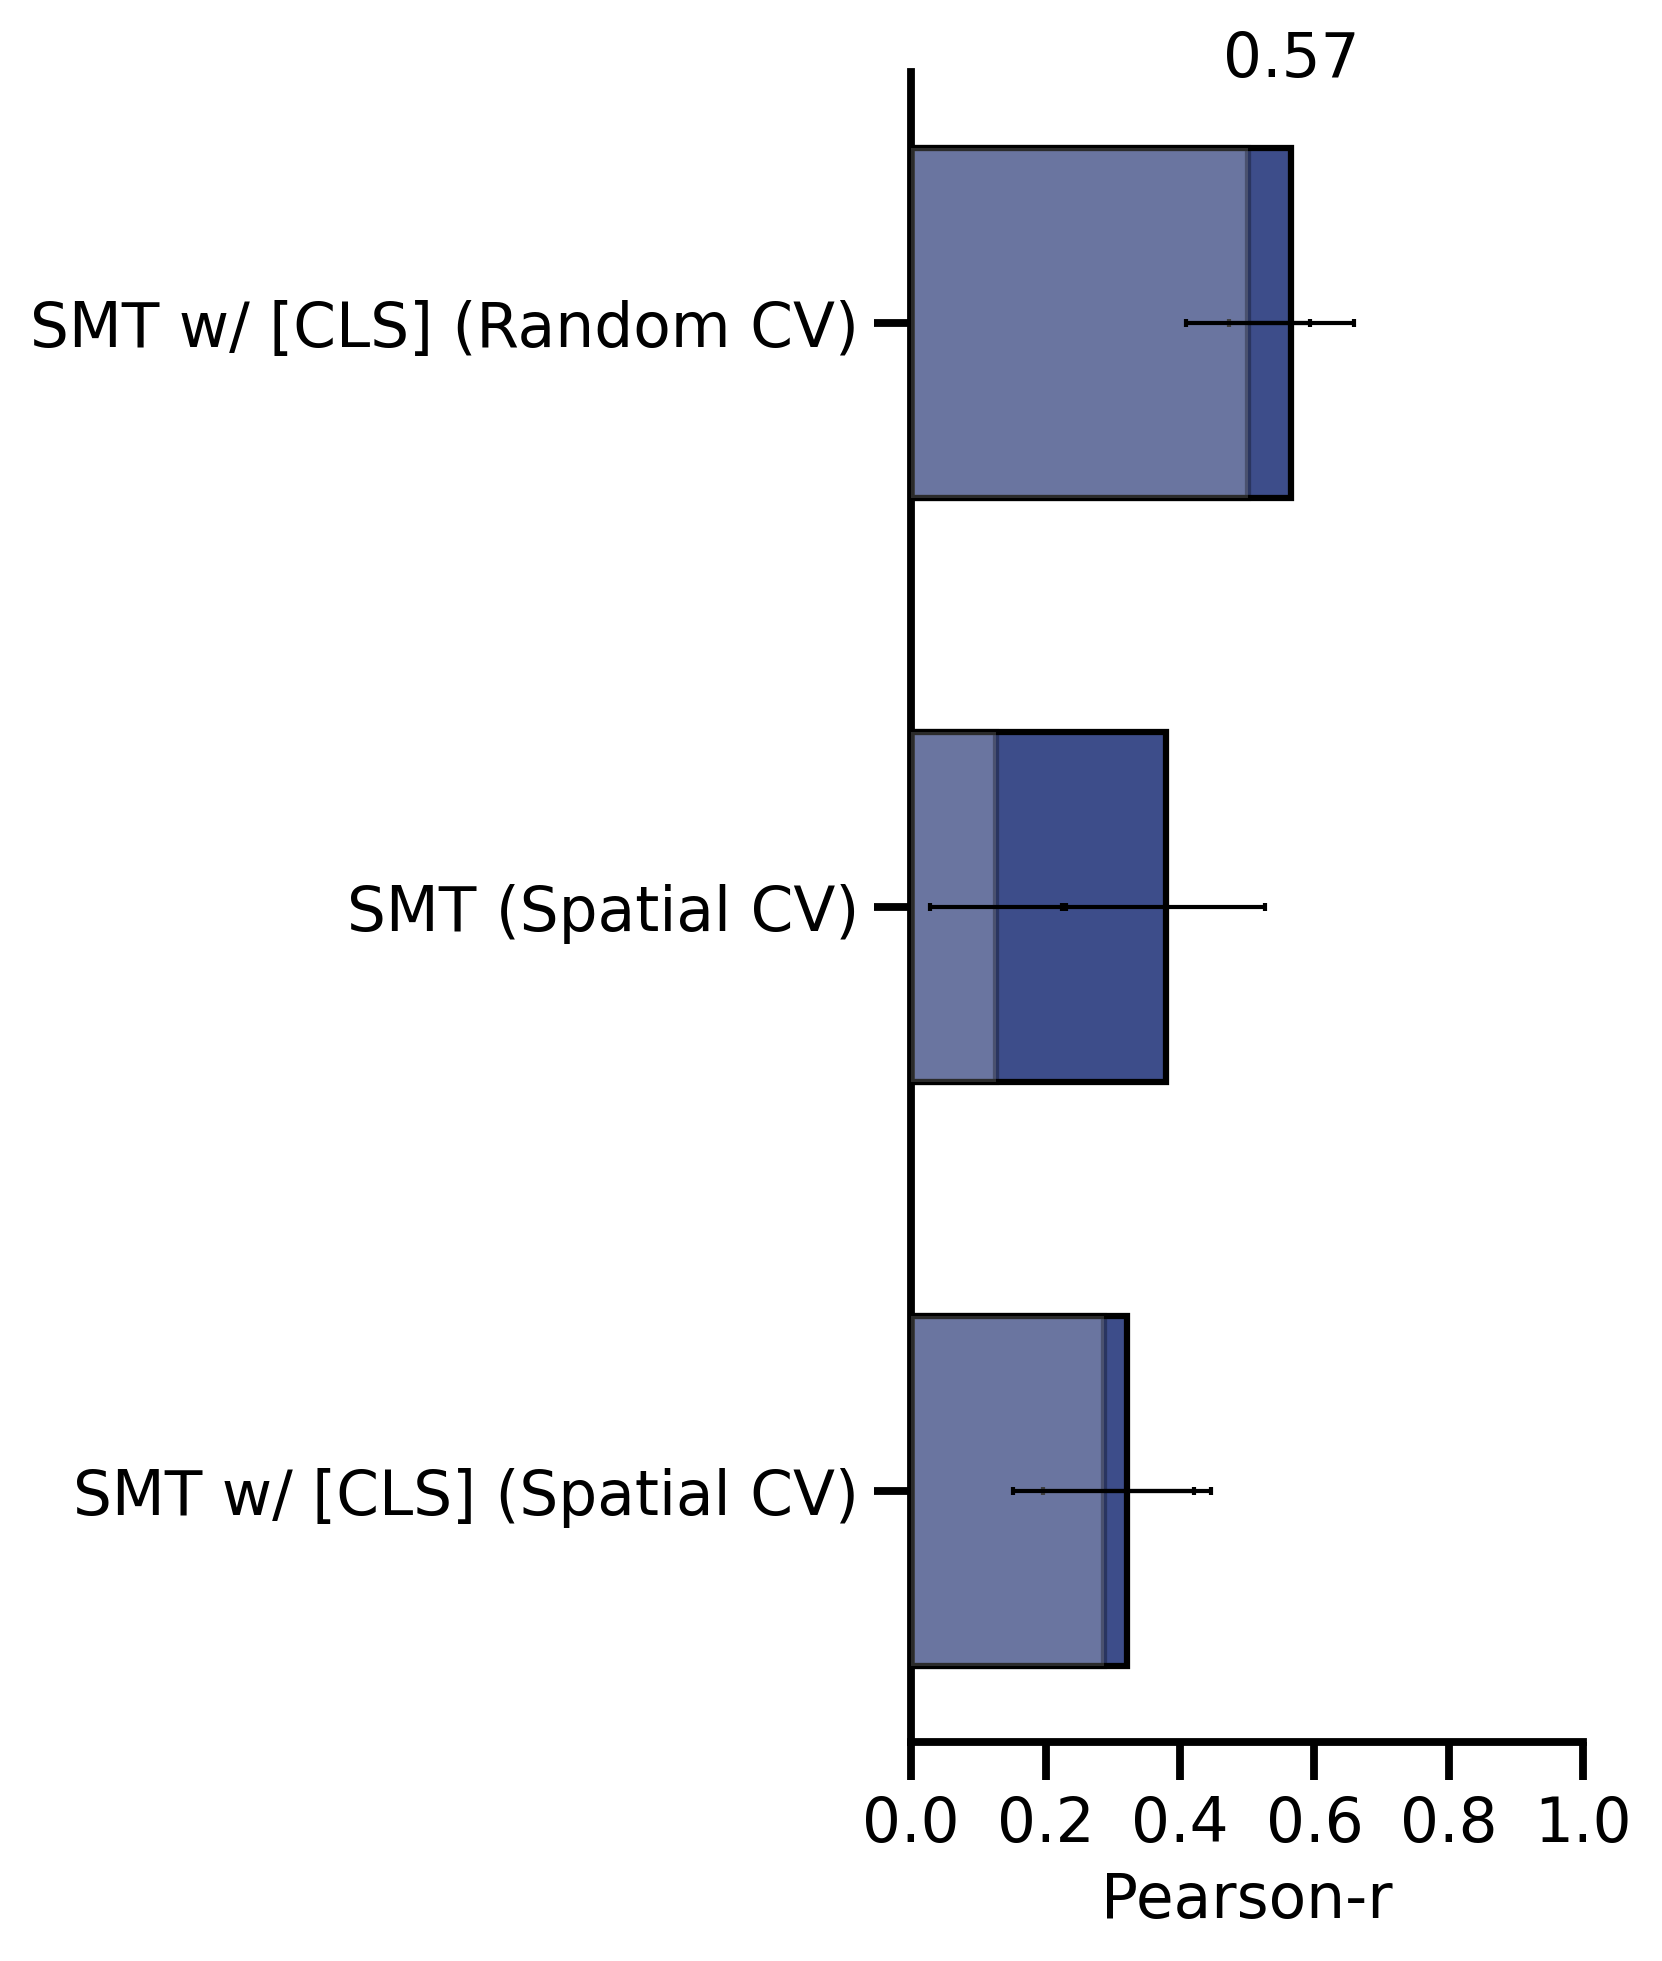

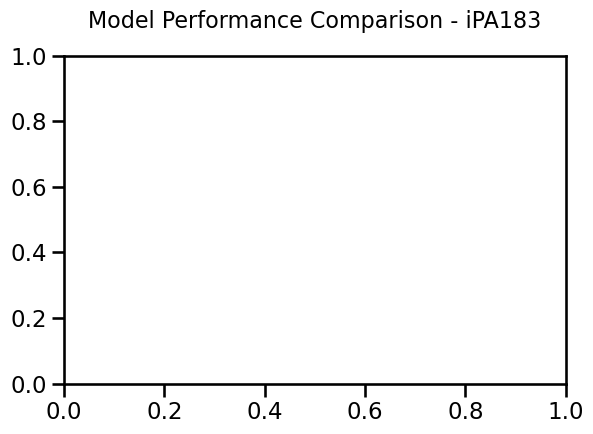


📈 Creating plots for dataset: iPA391


<Figure size 1000x600 with 0 Axes>

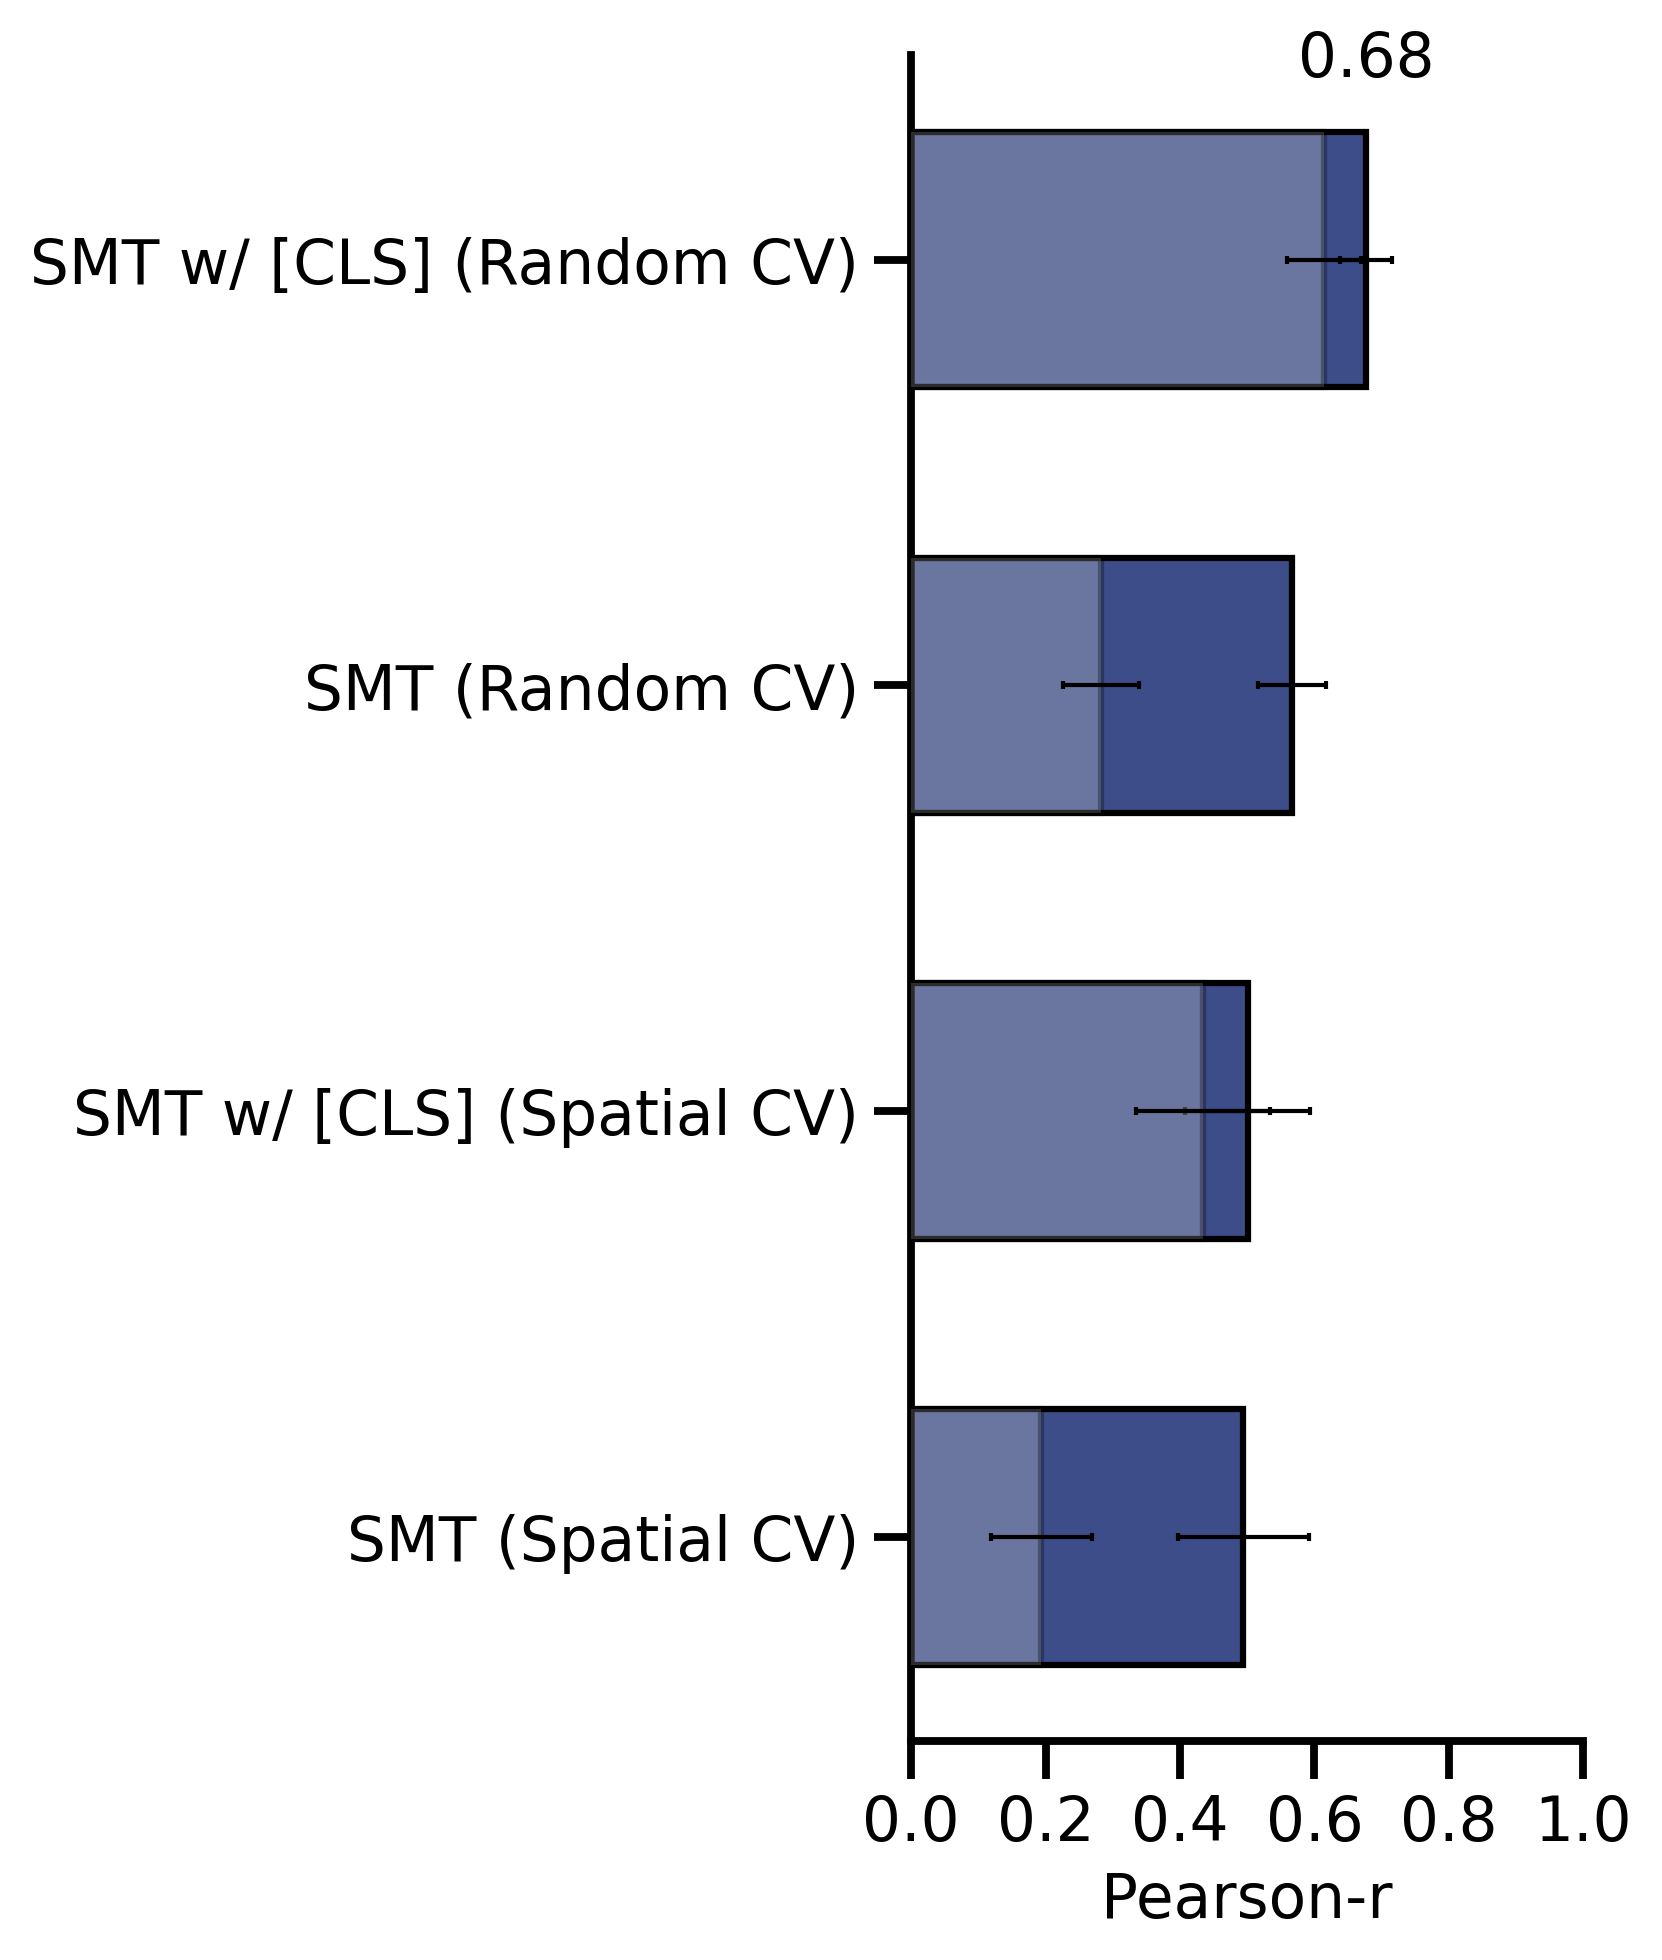

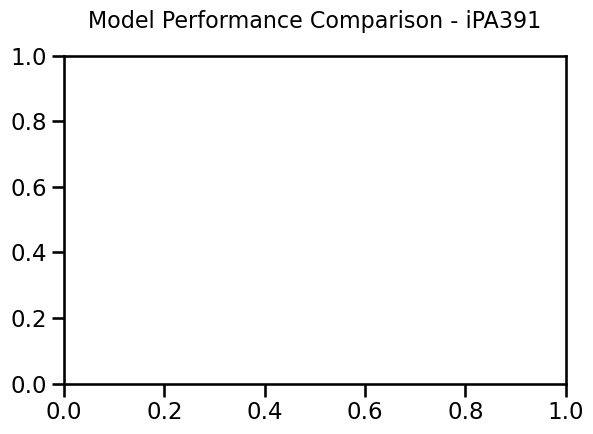


📈 Creating plots for dataset: iPA729


<Figure size 1000x600 with 0 Axes>

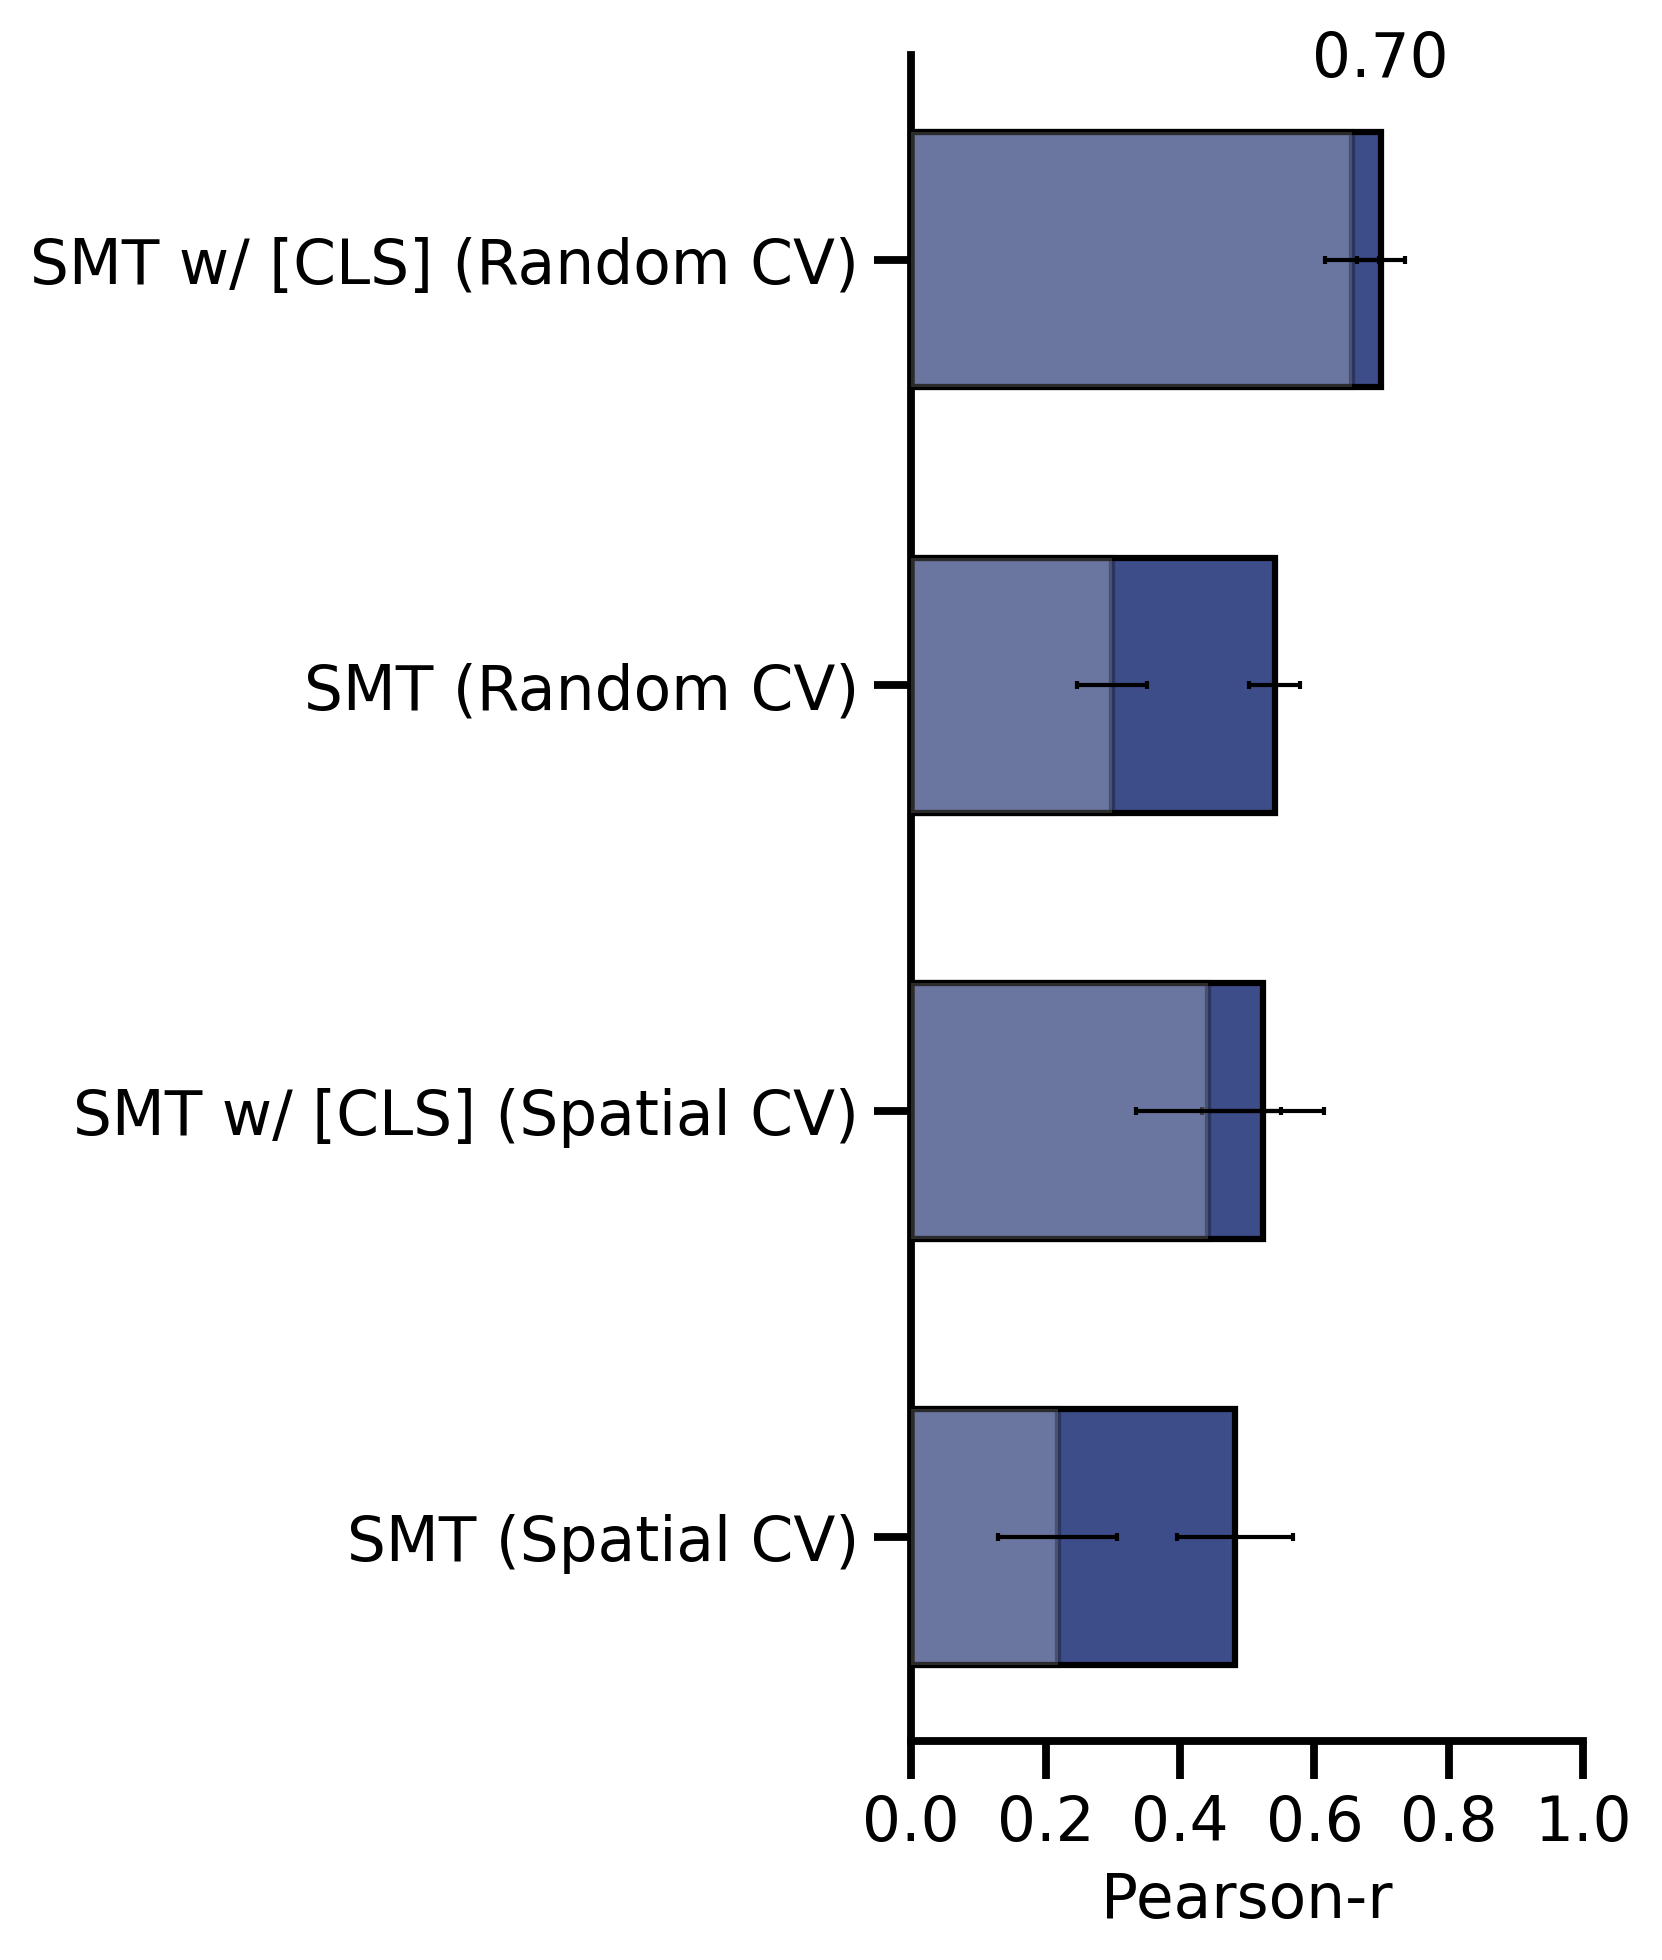

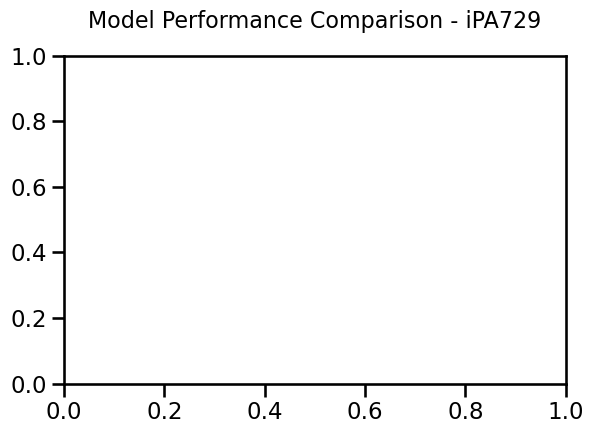


📈 Creating plots for dataset: HCP


<Figure size 1000x600 with 0 Axes>

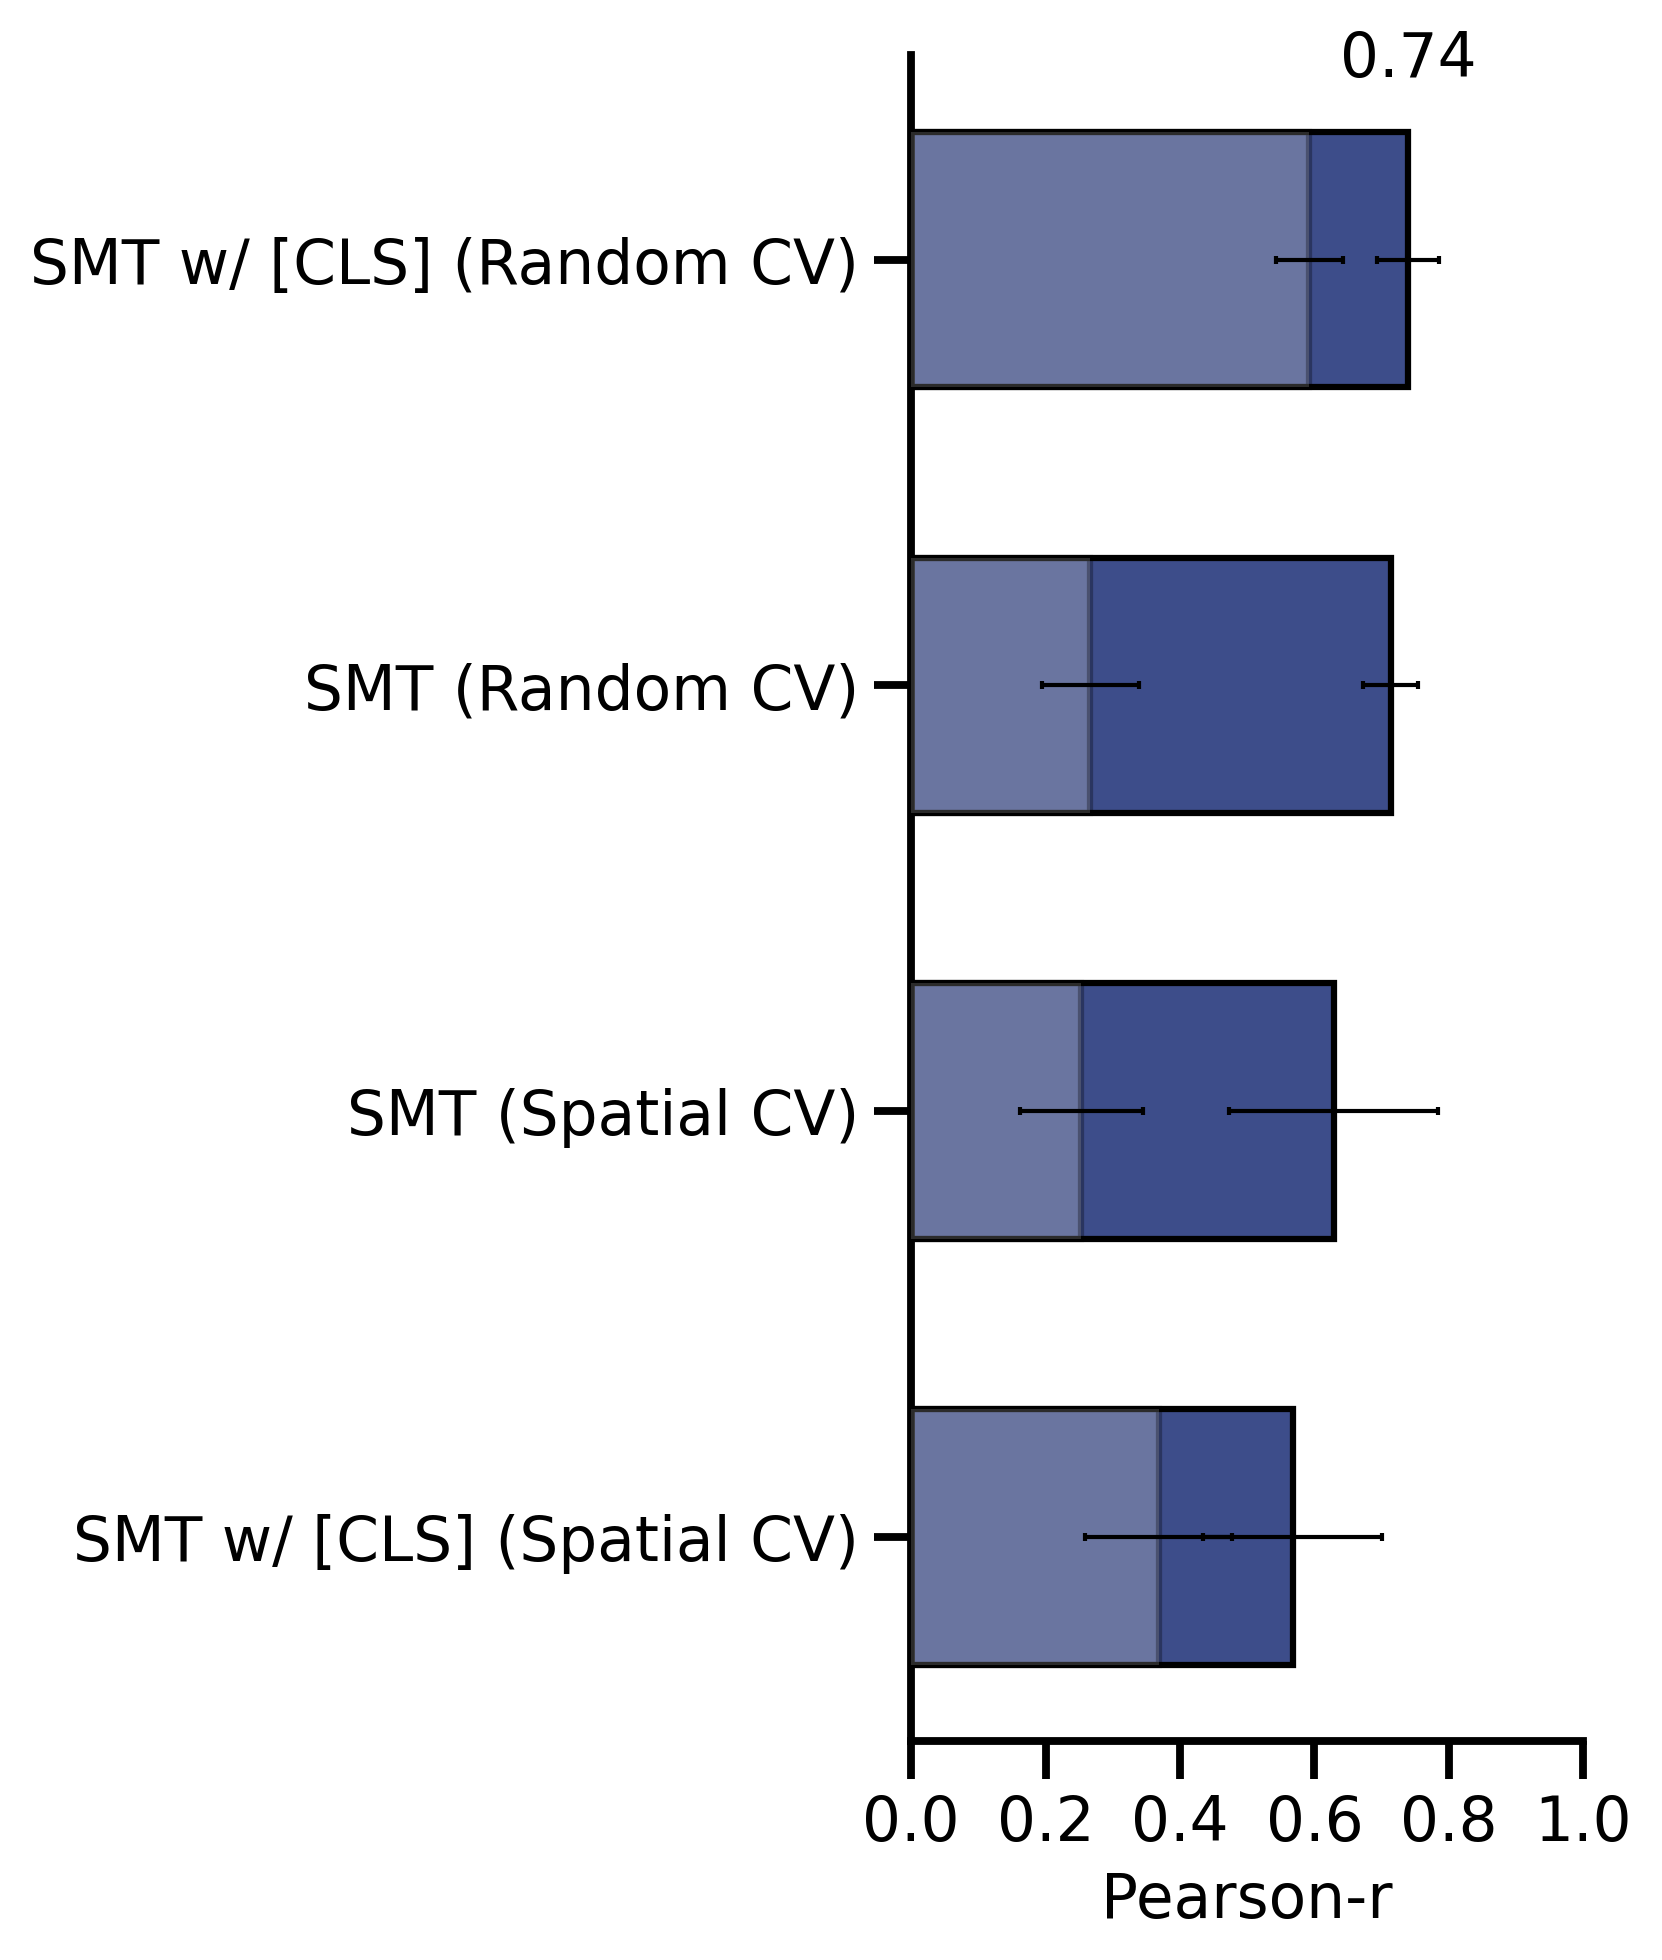

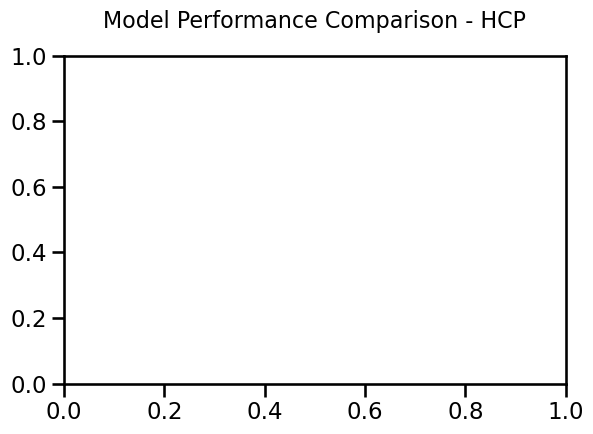

In [32]:
# Step 4: Create comparison plots
log_message("Creating comparison plots...")
create_comparison_plots(results)

In [33]:
# Step 5: Export to CSV
log_message("Exporting results to DF...")
export_df = export_results_to_df(results)
display(export_df)

[2025-11-17 11:55:34] INFO: Exporting results to DF...

EXPORTING RESULTS TO DF


,dataset,model,cv_type,null_model,status,test_geodesic_distance_mean,test_geodesic_distance_std,test_inter_hemi_r_mean,test_inter_hemi_r_std,test_left_hemi_r_mean,...,test_intra_network_Subcortical_r_mean,test_intra_network_Subcortical_r_std,test_intra_network_Vis_r_mean,test_intra_network_Vis_r_std,test_inter_network_Cerebellum_r_mean,test_inter_network_Cerebellum_r_std,test_intra_network_Cerebellum_r_mean,test_intra_network_Cerebellum_r_std,test_strong_neg_r_mean,test_strong_neg_r_std
0,iPA183,shared_transformer,random,none,missing,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,iPA183,shared_transformer,random,spin,missing,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,iPA183,shared_transformer,spatial,none,success,6.274649,0.810229,0.354479,0.183771,0.328818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,iPA183,shared_transformer,spatial,spin,success,7.015902,0.840312,0.132182,0.141721,0.124586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,iPA183,shared_transformer_cls,random,none,success,5.795501,1.105953,0.570393,0.092405,0.573134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,iPA183,shared_transformer_cls,random,spin,success,6.182954,0.928170,0.498198,0.098400,0.508773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,iPA183,shared_transformer_cls,spatial,none,success,7.013594,1.434066,0.306858,0.162440,0.298955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,iPA183,shared_transformer_cls,spatial,spin,success,7.279257,2.469534,0.277624,0.172217,0.287044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,iPA391,shared_transformer,random,none,success,8.168006,0.924300,0.558735,0.052181,0.596463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,iPA391,shared_transformer,random,spin,success,9.189293,0.630000,0.281637,0.061275,0.296442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
